In [6]:
import pickle
import warnings

import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Todos
 - Feature creation 
  - [x] add polynomial features
  - [ ] apply more transformations to the variables (log, etc.)
  - [ ] Do some dimensionality reduction / clustering to add features?
  - [ ] Run KNN on PCA'd features
 - Hyperparameter tuning
  - [ ] Grid search for all classifiers and meta classfiers
  - [A User's Guide to SVMs](http://pyml.sourceforge.net/doc/howto.pdf)
 - Model stacking / Pipelining / Ensembling
  - [ ] Review Kaggle posts / [approaches to model stacking](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/) 
  - [ ] Review Kaggle posts / approaches to multi-model voting
 - Model Diagnostics
  - [ ] run logistic regression (or another classifier) to get class probabilities.  Identify the data points that are getting low probabilities
  - [ ] create a pipeline for identifying the miss-classified datapoints and investigate the features that may be causing issues
  - [ ] See this [kaggle post](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Metrics to Evaluate Machine Learning Algorithms in Python](http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)
  - [Visulaizing Mistakes](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Model evaluation, model, selection, and algo selection Pt. 1](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html)
  

In [120]:
df = pd.read_csv('../data/clean/surveys.csv')

In [199]:
with open('./bad_data.pickle', 'rb') as f:
    bdf = pickle.load(f)

In [198]:
with open('./transative_df.pickle', 'rb') as f:
    tdf = pickle.load(f)

In [122]:
svo = df.loc[
    (df.svo.notnull()) & 
    (df.income!= 'Prefer not to answer') & 
    (df.ip != '104.200.153.94') &
    (df.age != 1234) & 
    (df.indoor.notnull()) & 
    ~(df._id.isin(bdf._id) )
, :]
svo.loc[:, 'income'] = svo.loc[:, 'income'].astype(int)
svo.loc[:, event_cols] = svo.loc[:, event_cols].fillna(0)
svo.reset_index(drop=True, inplace=True)

In [204]:
svo = pd.merge(svo, tdf, how='left', left_on='_id', right_on='session')

In [212]:
# svo[svo.case=='hard'][['transitive', 'case']]

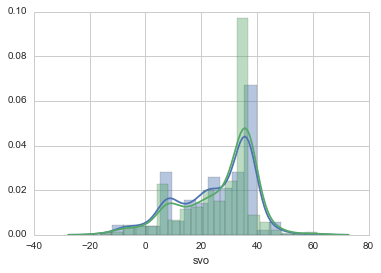

In [202]:
sns.distplot(df[df.svo.notnull()].svo)
sns.distplot(svo.svo)

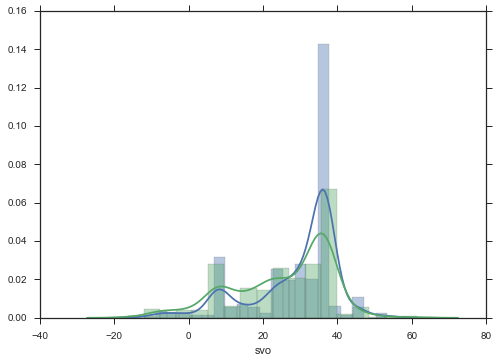

In [712]:
sns.distplot(svo[svo.case!='hard'].svo)
sns.distplot(df[df.svo.notnull()].svo)

### Features

In [213]:
event_cols = [
    'ev0', 'ev1', 'ev2',
    'ev3', 'ev4', 'ev5',
    'i0', 'i1', 'i2', 'i4'
]

In [214]:
interest_cols = [
    'health_fitness', 'indoor',
    'life_style', 'nature', 'outdoor',
    'performance_arts', 'sports', 'other'
]

In [215]:
demo_cols = [
    'age', 'income', 
    'education', 'politics',
    'religiosity', 'trust_development',
    'relationship_development',
    'dependence_development',
]

In [216]:
meta_cols = [
    'durationSeconds'
]

In [217]:
target_cols = interest_cols + demo_cols + meta_cols + event_cols

In [233]:
# sdf = svo[svo.case!='hard'].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
# tdf = svo[svo.case!='hard'].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
sdf = svo[svo.transitive].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
tdf = svo[svo.transitive].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')

In [234]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import minmax_scale

In [235]:
X = tdf.ix[:, 1:]
# X = sdf.ix[:, 1:]

In [236]:
X_scaled = minmax_scale(X)

In [237]:
y_svo = sdf.svo.as_matrix()
y_type = pd.factorize(tdf.type.as_matrix())[0]

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)

### Feature Engineering

In [23]:
from sklearn.preprocessing import PolynomialFeatures

In [24]:
poly = PolynomialFeatures(2)

In [25]:
EX = poly.fit_transform(X)

In [26]:
### Add interaction terms

### Modeling

In [224]:
from sklearn.grid_search import GridSearchCV

### OLS

In [225]:
# Y = list(svo.svo)

In [226]:
# X = list(svo.trust_development)

#### Scikits

In [239]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score

In [240]:
from sklearn.linear_model import LinearRegression

In [241]:
estimator = LinearRegression()

In [242]:
# estimator.fit(X, y_svo)
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -142.71


#### Statsmodels

In [243]:
model = sm.OLS(y_svo, X)

In [244]:
results = model.fit()

In [245]:
summary = results.summary()

In [246]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sat, 15 Apr 2017   Prob (F-statistic):          5.86e-207
Time:                        15:02:01   Log-Likelihood:                -2310.2
No. Observations:                 592   AIC:                             4674.
Df Residuals:                     565   BIC:                             4793.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
health_fitness               1.1167      1.123      0.994      0.320        -1.089     3.322
indoor                       4.0123      1.166      3.440      0.001         1.721     6.303
life_style                   1.1937      1.138      1.049      0.295        -1.042     3.429
nature                       3.2758      1.193      2.746      0.006         0.933     5.619
outdoor                     -0.4587      1.203     -0.381      0.703        -2.821     1.903
performance_arts            -2.0634      1.071     -1.926      0.055        -4.167     0.041
sports                       0.3694      1.060      0.348      0.728        -1.713     2.452
other                       -2.7990      2.983     -0.938      0.348        -8.657     3.059
age                          0.0016      0.001      1.125      0.261        -0.001     0.004
income                       0.2456      0.172      1.429      0.154        -0.092     0.583
education                    0.4270      0.383      1.115      0.265        -0.325     1.179
politics                    -0.8040      0.426     -1.886      0.060        -1.641     0.033
religiosity                  1.1742      0.396      2.964      0.003         0.396     1.952
trust_development            1.8254      0.551      3.316      0.001         0.744     2.907
relationship_development     1.4494      0.510      2.841      0.005         0.447     2.452
dependence_development      -0.1723      0.505     -0.341      0.733        -1.165     0.820
durationSeconds              0.0551      0.014      4.029      0.000         0.028     0.082
ev0                         -0.0042      0.004     -1.174      0.241        -0.011     0.003
ev1                          0.0121      0.003      4.479      0.000         0.007     0.017
ev2                         -0.0049      0.004     -1.121      0.263        -0.013     0.004
ev3                          0.0169      0.005      3.490      0.001         0.007     0.026
ev4                         -0.0619      0.008     -7.894      0.000        -0.077    -0.046
ev5                          0.0196      0.006      3.112      0.002         0.007     0.032
i0                          -0.2318      0.676     -0.343      0.732        -1.559     1.095
i1                          -1.0447      0.973     -1.074      0.283        -2.956     0.866
i2                          -3.6406      1.899     -1.917      0.056        -7.371     0.090
i4                          -0.4379      3.648     -0.120      0.904        -7.603     6.727
==============================================================================
Omnibus:                       17.831   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.727
Skew:                          -0.253   Prob(JB):       

### Random Forest Regressor

In [247]:
from sklearn.ensemble import RandomForestRegressor

In [248]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)

In [249]:
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -97.16


In [250]:
estimator.fit(X, y_svo)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [251]:
y_pred = estimator.predict(X)

In [253]:
r2_score(y_svo, y_pred)

0.92365633051572948

In [254]:
imp = pd.Series(estimator.feature_importances_)

### Ensemble Classifiers

In [255]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [67]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 20],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [68]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                             n_estimators=300)

In [47]:
rf_grid = GridSearchCV(rf_clf, param_grid=param_grid)

In [48]:
gb_grid = GridSearchCV(rf_clf, param_grid=param_grid)

In [55]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 150, 300]
             }

In [56]:
ab_grid = GridSearchCV(ab_clf, param_grid=param_grid)

In [70]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [1, 3, 10], 'max_features': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [74]:
rf_grid.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [69]:
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [1, 3, 10], 'max_features': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [75]:
gb_grid.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [57]:
ab_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=300, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'base_estimator__splitter': ['best', 'random'], 'base_estimator__criterion': ['gini', 'entropy'], 'n_estimators': [50, 150, 300]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [59]:
ab_grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=150, random_state=None)

In [257]:
score = cross_val_score(gb_grid.best_estimator_, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.83


In [256]:
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)
ab_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=300, random_state=None)

In [258]:
y_pred = rf_grid.best_estimator_.predict(X_test)

In [259]:
imp = pd.Series(estimator.feature_importances_)

In [260]:
feats = pd.DataFrame({'col':target_cols, 'imps': imp})

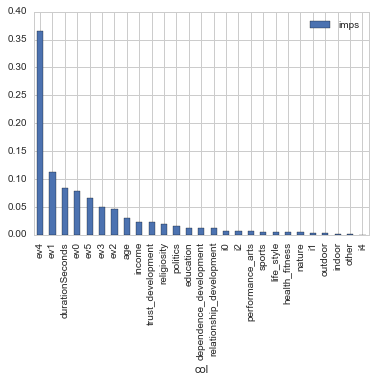

In [261]:
feats.sort_values('imps', ascending=False).plot(
    kind='bar', x=feats.sort_values('imps', ascending=False).col)

### Support Vector Machine

In [115]:
from sklearn.svm import SVC

In [162]:
svc_clf = SVC(C=10, kernel='linear', probability=True)

In [62]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [63]:
clf = GridSearchCV(estimator, param_grid)

In [163]:
svc_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
y_pred2 = estimator2.predict(X_test)

In [132]:
# clf.best_params_

In [178]:
# clf.best_estimator_

In [179]:
# clf.best_score_

In [177]:
# score = cross_val_score(clf.best_estimator_, X, y_type, cv=10).mean()
# print("Score with the entire dataset = %.2f" % score)

### KNN

In [262]:
from sklearn.neighbors import KNeighborsClassifier

In [263]:
knn_clf = KNeighborsClassifier()

In [689]:
param_grid = [{
    'weights': ['uniform', 'distance'], 
    'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'metric': ['euclidean', 'cityblock']
}]

In [690]:
knn_grid = GridSearchCV(knn_clf, param_grid)

In [691]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'metric': ['euclidean', 'cityblock']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [692]:
knn_grid.best_score_

0.79132231404958675

In [156]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [265]:
score = cross_val_score(knn_clf, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.81


### Voting Classifier

In [695]:
from sklearn.ensemble import VotingClassifier

In [698]:
vote_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_), 
        ('gb', gb_grid.best_estimator_), 
        ('knn', knn_grid.best_estimator_)
    ], voting='soft', weights=[1, 3, 2])

In [699]:
score = cross_val_score(vote_clf, X, y_type, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.80


### Autolearning Classifier

In [470]:
# import autosklearn.classification

### Diagnostics and Model Checking

In [59]:
## See how the model performs with more data

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [61]:
# classification_report(y_test, y_pred, target_names=f[1])

In [ ]:
# confusion_matrix(y_test, y_pred)

In [122]:
adf = pd.DataFrame({'train': y_test, 'test': y_pred})

In [125]:
adf['loss'] = adf.apply(lambda r: 1 if r['test'] == r['train'] else 0, axis=1)

In [138]:
f = pd.factorize(tdf.type.as_matrix())

In [150]:
# adf.replace({
#     0: 'individualistic',
#     1: 'prosocial',
#     2: 'altruistic',
#     3: 'competitive'
# })

### Learning Curve

In [111]:
scores = []
sizes = range(100, 700, 100)
for size in sizes:
    sample = svo.sample(size)
    df = sample.loc[:, ['type'] + target_cols]
    y = pd.factorize(df.type)[0]
    X = df.ix[:, 1:].as_matrix()
    score = cross_val_score(gb_grid.best_estimator_, X, y, cv=3).mean()
    scores.append(score)

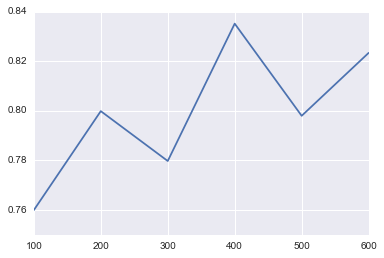

In [112]:
plt.plot(sizes, scores)
#list(sizes)

### ROC curve

In [142]:
from sklearn.metrics import roc_curve, auc

In [169]:
X.shape

(640, 27)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)

In [177]:
probs = gb_clf.predict_proba(X_test)
preds = probs[:,1]

In [178]:
probs2 = svc_clf.predict_proba(X_test)
preds2 = probs2[:,1]

In [179]:
probs3 = knn_clf.predict_proba(X_test)
preds3 = probs3[:,1]

In [180]:
probs4 = rf_clf.predict_proba(X_test)
preds4 = probs4[:,1]

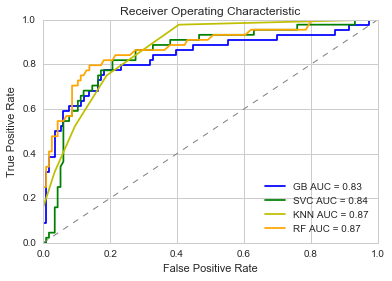

In [194]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, threshold = roc_curve(y_test, preds2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, threshold = roc_curve(y_test, preds3)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, threshold = roc_curve(y_test, preds4)
roc_auc4 = auc(fpr4, tpr4)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'GB AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'SVC AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'y', label = 'KNN AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'orange', label = 'RF AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='gray', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig("../img/roc.png")

In [551]:
probs = pd.Series(preds).apply(np.max)

In [188]:
adf['prob'] = probs

In [196]:
# adf[adf.loss==0]

### Identifying misclassified points

In [123]:
# Classifiers
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [195]:
clf = knn_clf

In [197]:
min_count = 0
runs = []
rdf = None
## train a classifier on anew training and testing set
while min_count <= 30:
    # Create placeholder vector
    run = np.full((1,X.shape[0],), np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=.25)
    # tet on the entire data set
    clf.fit(X_train, y_train)
    ## make predictions with the classifier
    y_pred = clf.predict(X_test)
    ## check if they're correct or incorrect
    misclassified = ~np.equal(y_pred, y_test)
#     print(pd.Series(misclassified).value_counts())
    # for each data point in the test set, if it's misclassified set the it's it's datapoint 
    # misclassified
    for dix, vix in enumerate(X_test.index):
        run[0][vix] = 1 if misclassified[dix] else 0
    runs.append(run[0])
    rdf = pd.DataFrame(runs)
    min_count = np.min(rdf.count())

IndexError: index 641 is out of bounds for axis 0 with size 640

In [135]:
hard_cases = rdf.mean()[rdf.mean() > .75].index
easy_cases = rdf.mean()[rdf.mean() == 0].index

In [136]:
svo.loc[hard_cases, 'case'] = 'hard'
svo.loc[easy_cases, 'case'] = 'easy'

In [138]:
# Style settings
sns.set_style('whitegrid')

def remove_gridlines(ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
def modify_gridlines(ax):
    for line in ax.get_ygridlines():
        line.set_linestyle(':')

    for line in ax.get_xgridlines():
        line.set_linestyle(':')

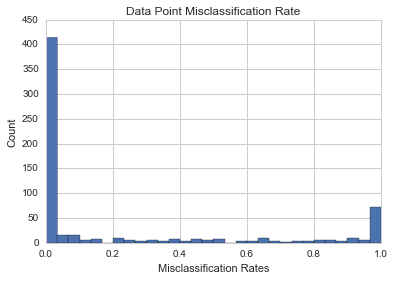

In [164]:
# Distribution of incorrect classifications
rdf.mean().hist(bins=30)
plt.title("Data Point Misclassification Rate")
plt.xlabel("Misclassification Rates")
plt.ylabel("Count")
plt.savefig("../img/misclassification_rate.png")

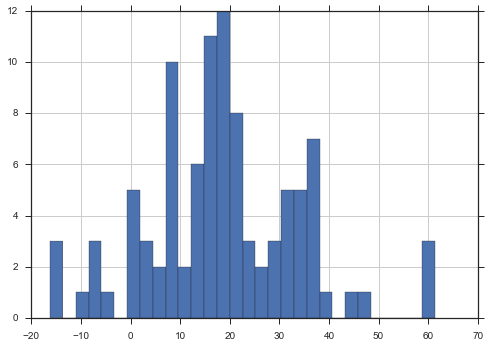

In [685]:
hard = svo.ix[hard_cases].svo.hist(bins=30)

In [587]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [588]:
cdf = svo.loc[:, ['case'] + target_cols]

In [589]:
X_clust = cdf.ix[cdf.case.notnull(), 1:]

In [590]:
X_clust_scaled = min_max_scaler.fit_transform(X_clust)

In [591]:
mds = MDS(2, max_iter=100, n_init=1)
tsne = TSNE(n_components=2, perplexity=50)
pca = PCA(n_components=2)

In [592]:
clust = tsne
X_mds = clust.fit_transform(X_clust_scaled)

In [593]:
mdf = pd.DataFrame({
    'x': X_mds.transpose()[0], 
    'y': X_mds.transpose()[1], 
    'case': cdf[cdf.case.notnull()].case
})

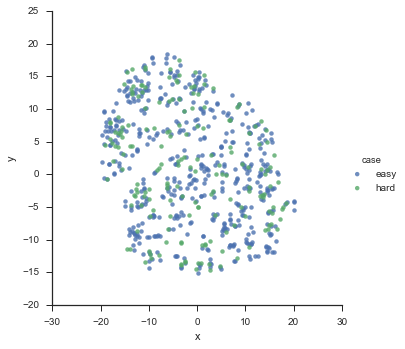

In [594]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='x', y='y', hue='case',
           fit_reg=False, data=mdf, scatter_kws={'alpha':0.8})

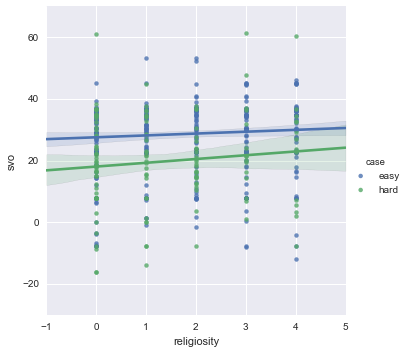

In [323]:
sns.lmplot(x='religiosity', y='svo', data=svo[svo.age < 100], hue='case')

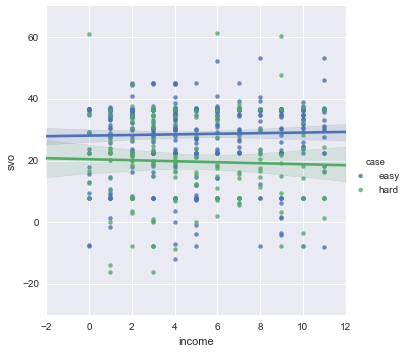

In [321]:
sns.lmplot(x='income', y='svo', data=svo[svo.age < 100], hue='case')

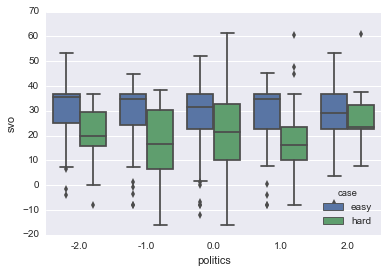

In [330]:
sns.boxplot(x='politics', y='svo', data=svo[svo.age < 100], hue='case')

In [636]:
### Check if the hard cases are in the bad values
hdf = svo.loc[svo.case=='hard', :]

AttributeError: 'DataFrame' object has no attribute 'case'

### Classifying Hard Cases

In [578]:
gb_hard_clf = GradientBoostingClassifier(n_estimators=300)
rf_hard_clf = RandomForestClassifier(n_estimators=300)
svc_hard_clf = SVC(C=1, kernel='linear', probability=False)
knn_hard_clf = knn_clf = KNeighborsClassifier(n_neighbors=10)

In [565]:
y_case = pd.factorize(svo.type)[0]

In [570]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(svo[target_cols], y_type, test_size=.25)

In [571]:
svc_hard_clf.fit(X_train_c, y_train_c)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [573]:
score = cross_val_score(svc_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.72


In [575]:
score = cross_val_score(gb_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.76


In [577]:
score = cross_val_score(rf_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.77


In [579]:
score = cross_val_score(knn_hard_clf, X_test, y_test, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.74


In [455]:
# case_pred = svc_hard_clf.predict(X_test_c)

In [ ]:
# confusion_matrix(case_pred, y_test_c)

In [ ]:
# score = cross_val_score(gb_hard_clf, svo[target_cols], y_case, cv=3).mean()
# print("Score with the entire dataset = %.2f" % score)

In [ ]:
# np.argmax(gb_hard_clf.feature_importances_)

target_cols[16]

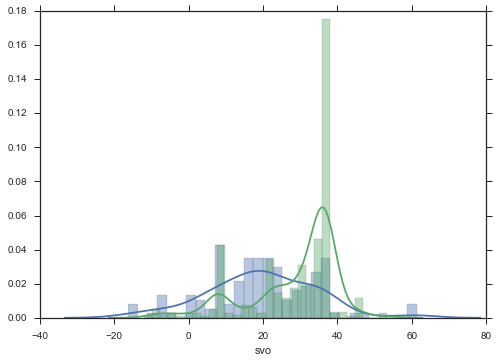

In [411]:
# sns.set(style="ticks", color_codes=True)
# g = sns.FacetGrid(svo[svo.notnull()], col="case")
# g = g.map(plt.hist, "svo", bins=30)
sns.distplot(svo[svo.case=='hard'].svo, bins=30)
sns.distplot(svo[svo.case=='easy'].svo, bins=30)

In [344]:
# sns.lmplot(x='ev4', y='svo', data=svo, hue='case')

In [302]:
# X = cluster_df.ix[:, 1:].as_matrix()
# X_scaled = min_max_scaler.fit_transform(X)

In [174]:
# np.in1d(y_pred, y_test)

In [564]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

### Reviewing classification probabilities